In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
LEVEL_CONFIGS = np.arange(0,2,0.002)

def generate_template_depth_mask(image_size, level_configs = np.arange(0,2,0.002)):
    H2, W2 = image_size[0]*2, image_size[1]*2
    H, W = image_size[0], image_size[1]
    num_levels = len(level_configs) + 1
    central_point = [H, W]
    depth_mask_template = torch.zeros(H2, W2, dtype=float)
    print(depth_mask_template.shape)
    for level_scale in level_configs:
        x1_bias = int(H * level_scale / 2)
        x2_bias = int(W * level_scale / 2)
        x1_min = max(0, H - x1_bias)
        x1_max = min(H2, H + x1_bias)
        x2_min = max(0, W - x2_bias)
        x2_max = min(W2, W + x2_bias)
        depth_mask_template[x1_min:x1_max, x2_min:x2_max] += 1
    return depth_mask_template / num_levels

def generate_template_depth_mask_power(image_size, level_configs = np.arange(0,2,0.002)):
    H2, W2 = image_size[0]*2, image_size[1]*2
    H, W = image_size[0], image_size[1]
    num_levels = len(level_configs) + 1
    central_point = [H, W]
    depth_mask_template = torch.zeros(H2, W2, dtype=float)
    print(depth_mask_template.shape)
    for level_scale in level_configs ** 2 / 2:
        x1_bias = int(H * level_scale / 2)
        x2_bias = int(W * level_scale / 2)
        x1_min = max(0, H - x1_bias)
        x1_max = min(H2, H + x1_bias)
        x2_min = max(0, W - x2_bias)
        x2_max = min(W2, W + x2_bias)
        depth_mask_template[x1_min:x1_max, x2_min:x2_max] += 1
    return depth_mask_template / num_levels

def generate_template_depth_mask_circular(image_size, level_configs = np.arange(0,2,0.002)):
    H2, W2 = image_size[0]*2, image_size[1]*2
    H, W = image_size[0], image_size[1]
    num_levels = len(level_configs) + 1
    all_points = np.meshgrid(np.arange(H2), np.arange(W2), indexing='ij')
    all_points = np.stack(all_points, axis = -1)
    
    print(all_points.shape)
    central_point = np.array([H, W])
    diff_points = all_points - central_point
    dist_to_central = np.linalg.norm(diff_points, axis = -1)
    
    depth_mask_template = torch.zeros(H2, W2, dtype=float)
    print(depth_mask_template.shape)
    for level_scale in level_configs:
        r = int(min(H, W) * level_scale / 2)
        points = all_points[dist_to_central <= r]
        depth_mask_template[points[:,0], points[:,1]] += 1
    return depth_mask_template / num_levels

def vanishing_point_to_depth_mask(vanishing_point, image_size, level_configs = np.arange(0,2,0.002), mask_func = generate_template_depth_mask):
# vanishing_points: sequence of tuples, in pixel
# image_size: tuple (H, W)
    if not hasattr(vanishing_point_to_depth_mask, "template"):
        vanishing_point_to_depth_mask.template = mask_func(image_size, level_configs) #(2H, 2W)

    H, W = image_size[0], image_size[1]
    x1, x2 = int(vanishing_point[0]), int(vanishing_point[1])
    bias1, bias2 = int(x1-H/2), int(x2-W/2)
    c1, c2 = H+bias1, W+bias2
    x1_min = int(c1-H/2)
    x1_max = int(c1+H/2)
    x2_min = int(c2-W/2)
    x2_max = int(c2+W/2)
    return vanishing_point_to_depth_mask.template[x1_min:x1_max, x2_min:x2_max]


def vanishing_point_to_depth_mask_batch(vanishing_points, image_size, level_configs = LEVEL_CONFIGS):
# vanishing_points: sequence of tuples, in pixel
# image_size: tuple (D1, D2)
    D1, D2 = image_size[0], image_size[1]
    B = len(vanishing_points)
    depth_masks = torch.zeros(B, 1, D1, D2, dtype=float)
    for i_batch in range(B):
        depth_masks[i_batch,0] = vanishing_point_to_depth_mask(vanishing_points[i_batch], image_size, level_configs)
    return depth_masks

In [3]:
vanishing_point = (1024 - 820, 700)
# image_size = (1920, 1080)
image_size = (1024, 1024)
LEVEL_CONFIGS = np.arange(0,2,0.002)


torch.Size([2048, 2048])


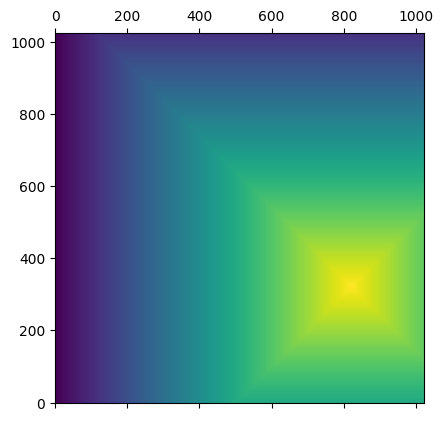

In [4]:
depth_mask = vanishing_point_to_depth_mask(vanishing_point, image_size, LEVEL_CONFIGS, generate_template_depth_mask)
fig, ax = plt.subplots(1)
ax.matshow(depth_mask.T, origin = "lower")

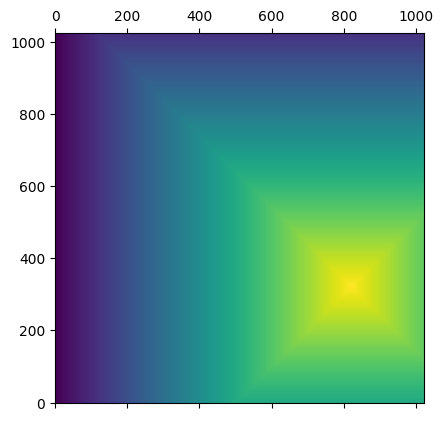

In [9]:
depth_mask = vanishing_point_to_depth_mask(vanishing_point, image_size, LEVEL_CONFIGS, generate_template_depth_mask_power)
fig, ax = plt.subplots(1)
ax.matshow(depth_mask.T, origin = "lower")

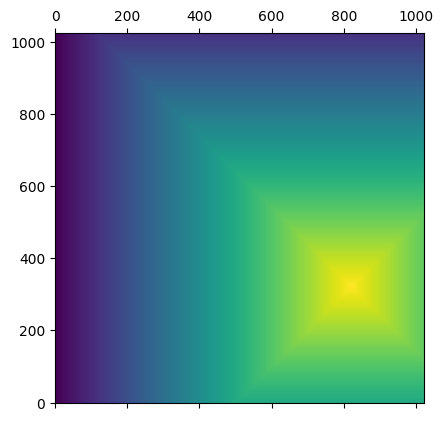

In [10]:
LEVEL_CONFIGS_CIRC = np.arange(0,2,0.01)

depth_mask = vanishing_point_to_depth_mask(vanishing_point, image_size, LEVEL_CONFIGS_CIRC, generate_template_depth_mask_circular)
fig, ax = plt.subplots(1)
ax.matshow(depth_mask.T, origin = "lower")

In [11]:
@torch.no_grad()
def select_roi(n_depth_levels, depth_mask):
    roi_region_sizes = [64,128,256] 
    roi_kernel_sizes = [1,3,5]
    
    B, _, H, W = depth_mask.shape
    img_size = (H,W)
    N = n_depth_levels
    
    # max_val: (B,1,1,1)
    max_val = torch.amax(depth_mask, dim=(2, 3)).unsqueeze(-1).unsqueeze(-1)

    # max_val_ids: (L,4), e.g., [[0,0,0,0], [0,0,0,1],..., [3,0,16,501]] (list of max_value_points)
    max_val_ids = (depth_mask == max_val).nonzero()
    
    # format: [[(h,w) for depth_lvls] for batch], -1 (default) means not-applicable
    min_ids = torch.zeros(B,N,2).long() - 1 # lower-left anchor point, (B,N,2)
    max_ids = torch.zeros(B,N,2).long() - 1 # upper-right anchor point, (B,N,2)
    roi_regions_masks = torch.zeros(B,N,H,W)
    
    for i_data in range(B):
        central_id = max_val_ids[max_val_ids[:,0] == i_data].float().mean(dim = 0).long()[2:] # (h,w)
        if central_id[0] % 4 != 0:
            central_id[0] = central_id[0] - central_id[0] % 4
        if central_id[1] % 4 != 0:
            central_id[1] = central_id[1] - central_id[1] % 4
        this_max_val = max_val[i_data].cpu().detach().item()
        for i_depth in range(N):
            # min_id = torch.clamp(central_id - roi_region_sizes[i_depth] / 2, min=0, max=H).long()
            # max_id = torch.clamp(central_id + roi_region_sizes[i_depth] / 2, min=0, max=H).long()
            min_id = (central_id - roi_region_sizes[i_depth] / 2).long()
            max_id = (central_id + roi_region_sizes[i_depth] / 2).long()

            for i_axis in range(2):
                if min_id[i_axis] < 0:
                    max_id[i_axis] += - min_id[i_axis]
                    min_id[i_axis] = 0

                if max_id[i_axis] > img_size[i_axis]:
                    min_id[i_axis] -= max_id[i_axis] - img_size[i_axis]
                    max_id[i_axis] = img_size[i_axis]

            if (min_id + roi_kernel_sizes[i_depth] < max_id).all():
                min_ids[i_data,i_depth,:] = min_id
                max_ids[i_data,i_depth,:] = max_id
                roi_regions_masks[i_data,i_depth,min_id[0]:max_id[0],min_id[1]:max_id[1]] = 1
    
    return roi_regions_masks, min_ids, max_ids



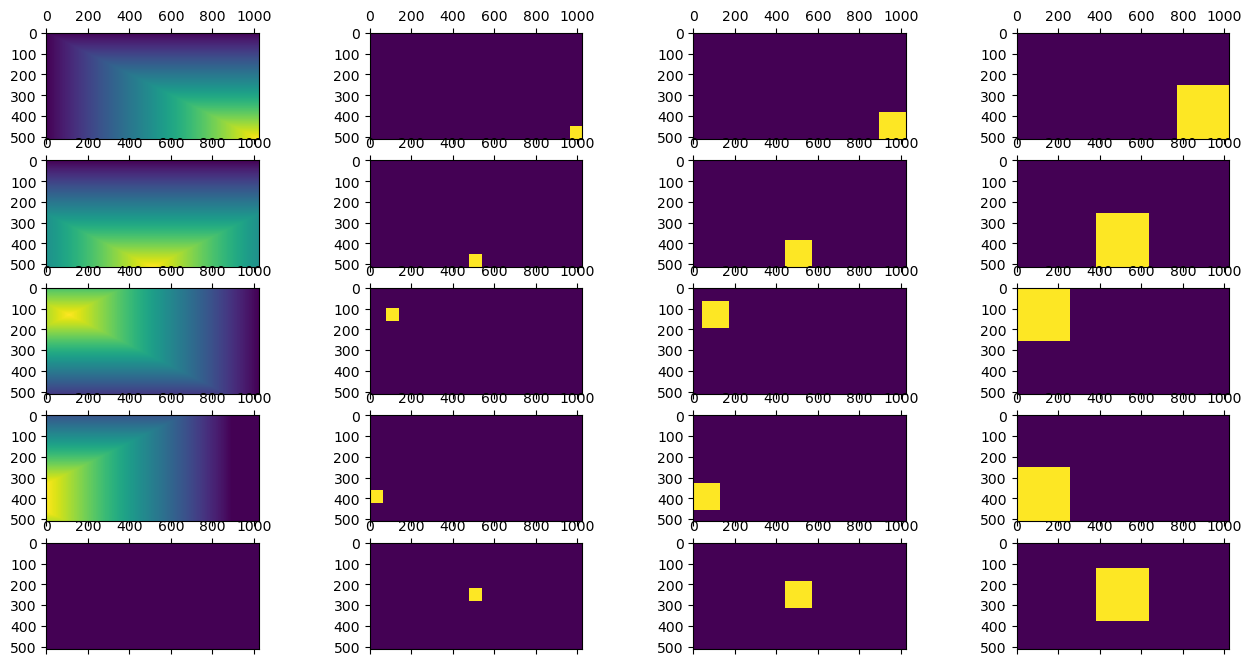

In [16]:
n_depth_levels = 3
roi_regions_masks, min_ids, max_ids = select_roi(n_depth_levels, depth_masks)

B, _, H, W = depth_masks.shape
n_depth_levels = 3
fig, ax = plt.subplots(B, n_depth_levels+1, figsize=(16,8))
for i_data in range(B):
    ax[i_data,0].matshow(depth_masks[i_data].permute(2,1,0))
    for i_depth in range(n_depth_levels):
        ax[i_data,i_depth+1].matshow(roi_regions_masks[i_data,i_depth:i_depth+1].permute(2,1,0))
        

In [79]:
@torch.no_grad()
def select_roi_simple(n_depth_levels, depth_mask):
    roi_region_sizes = [64,128,256] 
    roi_kernel_sizes = [1,3,5]
    
    B, _, H, W = depth_mask.shape
    N = n_depth_levels
    
    # format: [[(h,w) for depth_lvls] for batch], -1 (default) means not-applicable
    roi_regions_masks = torch.zeros(B,N,H,W).to(float)
    
    for i_depth in range(N):
        roi_regions_masks[:,i_depth:,:,:] = (depth_mask >= (N - i_depth)).to(float)
    
    return roi_regions_masks

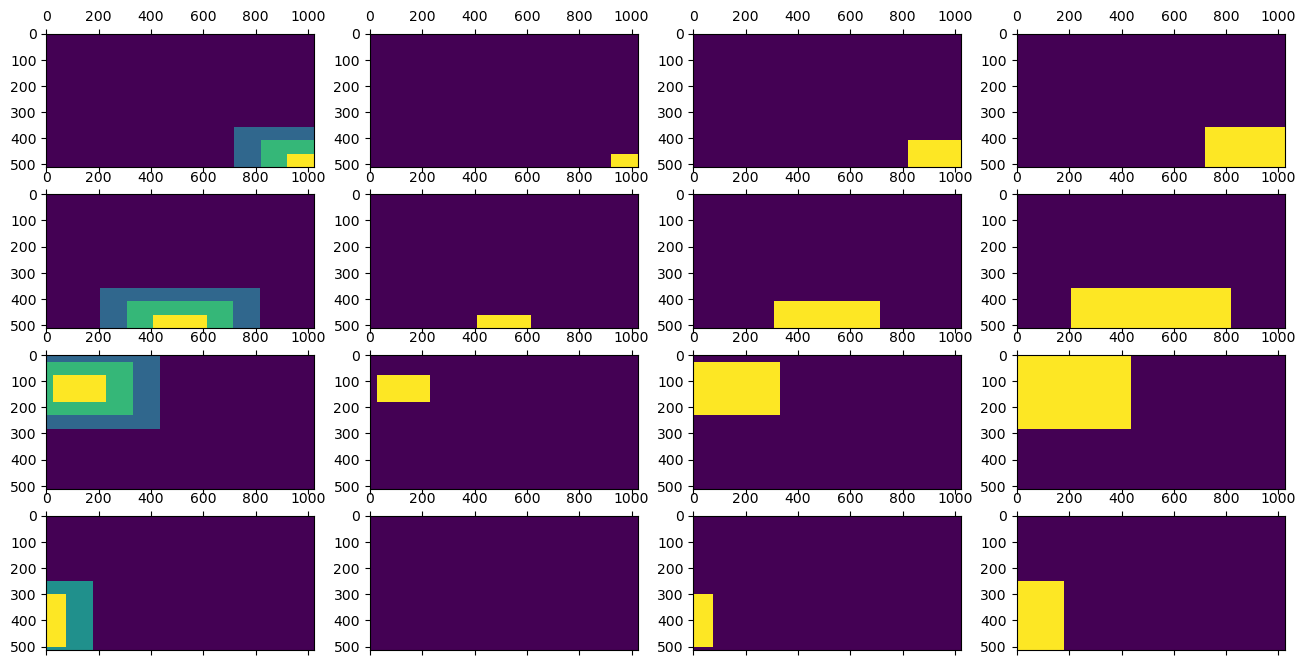

In [80]:
roi_regions_masks = select_roi_simple(n_depth_levels, depth_masks)

B, _, H, W = depth_masks.shape
n_depth_levels = 3
fig, ax = plt.subplots(B, n_depth_levels+1, figsize=(16,8))
for i_data in range(B):
    ax[i_data,0].matshow(depth_masks[i_data].permute(2,1,0))
    for i_depth in range(n_depth_levels):
        ax[i_data,i_depth+1].matshow(roi_regions_masks[i_data,i_depth:i_depth+1].permute(2,1,0))

In [5]:
from PIL import Image
import numpy as np

img_path1 = "327-gen.png"
img_path2 = "BIDMC-Case00-12.png"
img1 = np.array(Image.open(img_path1))
img2 = np.array(Image.open(img_path2))

In [15]:
img2.shape

(128, 128, 3)